In [41]:

# cd drive/MyDrive/Colab\ Notebooks/


In [42]:
# ls

# Imports + Setup

In [1]:
import os, re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt

In [2]:
# Set seeds for reproducibility
import random
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CUDA
torch.backends.cudnn.benchmark = False      # Disable auto-tuner that can introduce randomness

In [3]:
# File Mapping
h_map = {2: 0.0375, 3: 0.084, 6: 0.1575}
flux_map = {88: 25900, 78: 21250, 73: 19400}
abs_map = {0: 3, 92: 100}
surf_map = {0: 0.98, 1: 0.76}
pattern = r"h(\d+)_flux(\d+)_abs(\d+)(?:_[A-Za-z0-9]+)*_surf([01])(?:_[A-Za-z0-9]+)*[\s_]+(\d+)s\b"
# Depending on where u store the data files
# cd drive/MyDrive/Colab\ Notebooks/Theoretical_VTDP
DATA_DIR = "../../data/Theoretical_VTDP"
# DATA_DIR = "Theoretical_VTDP/"
DROP_COLS = ["TC_9_5", "TC_Bottom_rec_groove", "TC_wall_ins_ext", "TC_bottom_ins_groove", "Theoretical_Temps_11"]

# Utilities

In [4]:
def parse_filename_params(filename):
    m = re.search(pattern, filename)
    if not m:
        return None
    h_raw    = int(m.group(1))
    flux_raw = int(m.group(2))
    abs_raw  = int(m.group(3))
    surf_raw = int(m.group(4))
    t        = int(m.group(5))

    # keeping number if no entry exists
    h    = h_map.get(h_raw,    h_raw)
    flux = flux_map.get(flux_raw, flux_raw)
    abs_ = abs_map.get(abs_raw,  abs_raw)
    surf = surf_map.get(surf_raw)

    return h, flux, abs_, surf, t

def load_and_process_file(path, h, flux, abs_val, surf, min_time):
    df = pd.read_csv(path, encoding="utf-8-sig")
    df = df[df["Time"] >= min_time].copy()
    df.drop(columns=[col for col in df.columns if col in DROP_COLS or col.startswith("Depth_")], inplace=True)
    df["h"] = h
    df["flux"] = flux
    df["abs"] = abs_val
    df["surf"] = surf
    return df

# Load and Combine Data

In [5]:
dataframes = []
for fname in os.listdir(DATA_DIR):
    if not fname.endswith(".csv"):
        continue
    params = parse_filename_params(fname)
    if params is None or params[3] is None:
        print("Skipping:", fname)
        continue
    path = os.path.join(DATA_DIR, fname)
    df = load_and_process_file(path, *params)
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)
print(data.info())
print(data.head())


Skipping: h2_flux88_abs25_wr_surfParAdded_169s - Sheet1_processed.csv
Skipping: h2_flux88_abs25_wr_surfSimD_525s - Sheet1_processed.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66146 entries, 0 to 66145
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  66146 non-null  int64  
 1   TC1_tip               66146 non-null  float64
 2   TC2                   66146 non-null  float64
 3   TC3                   66146 non-null  float64
 4   TC4                   66146 non-null  float64
 5   TC5                   66146 non-null  float64
 6   TC6                   66146 non-null  float64
 7   TC7                   66146 non-null  float64
 8   TC8                   66146 non-null  float64
 9   TC9                   66146 non-null  float64
 10  TC10                  66146 non-null  float64
 11  Theoretical_Temps_1   66146 non-null  float64
 12  Theoretical_Temps_2   66146 non-null

# Preprocessing

In [6]:
# 1. Extract input (X) and output (y) columns
theory_cols = [c for c in data.columns if c.startswith("Theoretical_Temps_")]
X = data[["Time", "h", "flux", "abs", "surf"] + theory_cols]
y = data.drop(columns=["Time", "h", "flux", "abs", "surf"] + theory_cols)
y_columns = y.columns  # For inverse transform after prediction

# 2. Split into train, val, test before scaling
X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(X_temp_raw, y_temp_raw, test_size=0.5, random_state=SEED)

# 3. Scale using only training set statistics
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train_raw)
X_val_scaled   = X_scaler.transform(X_val_raw)
X_test_scaled  = X_scaler.transform(X_test_raw)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_val_scaled   = y_scaler.transform(y_val_raw)
y_test_scaled  = y_scaler.transform(y_test_raw)

joblib.dump(X_scaler, "X_scaler.pkl")
joblib.dump(y_scaler, "y_scaler.pkl")

# 4. Convert to PyTorch tensors for training
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val   = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test  = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val   = torch.tensor(y_val_scaled, dtype=torch.float32)
y_test  = torch.tensor(y_test_scaled, dtype=torch.float32)


# Model

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.net(x)

input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = NeuralNet(input_size, output_size)

# Training

In [8]:
# ✅ Define loss and optimizer
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 500

# ✅ For storing loss per epoch
train_losses = []
val_losses = []

# ✅ Training loop
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass + loss
    predictions = model(X_train)
    train_loss = 0.7 * mse_loss(predictions, y_train) + 0.3 * mae_loss(predictions, y_train)
    
    # Backward pass + optimization
    train_loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = 0.7 * mse_loss(val_preds, y_val) + 0.3 * mae_loss(val_preds, y_val)

    # Save losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.6f}, Val Loss: {val_loss.item():.6f}")
torch.save(model.state_dict(), "thermal_model_weights.pth")

Epoch [50/500], Train Loss: 0.040192, Val Loss: 0.034480
Epoch [100/500], Train Loss: 0.029732, Val Loss: 0.017848
Epoch [150/500], Train Loss: 0.026116, Val Loss: 0.016812
Epoch [200/500], Train Loss: 0.024000, Val Loss: 0.016089
Epoch [250/500], Train Loss: 0.022537, Val Loss: 0.015616
Epoch [300/500], Train Loss: 0.021424, Val Loss: 0.015127
Epoch [350/500], Train Loss: 0.020679, Val Loss: 0.014776
Epoch [400/500], Train Loss: 0.020110, Val Loss: 0.014473
Epoch [450/500], Train Loss: 0.019529, Val Loss: 0.014341
Epoch [500/500], Train Loss: 0.019241, Val Loss: 0.014515


# Evaluation

In [9]:
model.eval()
with torch.no_grad():
    preds = model(X_test).numpy()

preds_real = y_scaler.inverse_transform(preds)
y_real = y_scaler.inverse_transform(y_test.numpy())
rmse = np.sqrt(np.mean((preds_real - y_real) ** 2, axis=0))

print("\nRMSE per output (°C):")
for col, val in zip(y.columns, rmse):
    print(f"{col}: {val:.3f} °C")

print(f"\nAverage RMSE across all outputs: {np.mean(rmse):.3f} °C")

mae = np.mean(np.abs(preds_real - y_real), axis=0)

print("\nMAE per output (°C):")
for col, val in zip(y.columns, mae):
    print(f"{col}: {val:.3f} °C")

print(f"\nAverage MAE across all outputs: {np.mean(mae):.3f} °C")



RMSE per output (°C):
TC1_tip: 31.111 °C
TC2: 30.526 °C
TC3: 31.563 °C
TC4: 31.422 °C
TC5: 31.060 °C
TC6: 30.907 °C
TC7: 31.387 °C
TC8: 32.135 °C
TC9: 33.797 °C
TC10: 35.613 °C

Average RMSE across all outputs: 31.952 °C

MAE per output (°C):
TC1_tip: 7.214 °C
TC2: 7.051 °C
TC3: 8.532 °C
TC4: 9.178 °C
TC5: 8.416 °C
TC6: 8.506 °C
TC7: 8.772 °C
TC8: 9.327 °C
TC9: 11.380 °C
TC10: 16.395 °C

Average MAE across all outputs: 9.477 °C


<!-- ----------------------------------------------------------------------------------------------------------------------------------- -->

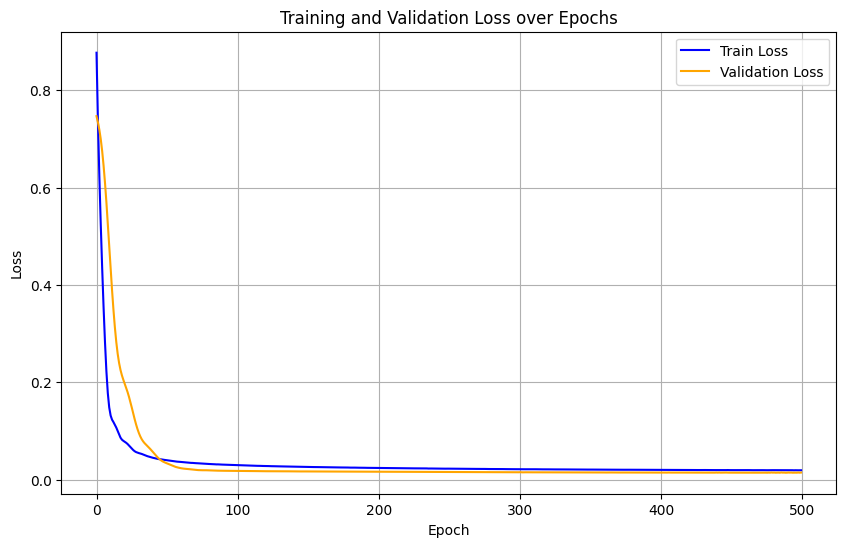

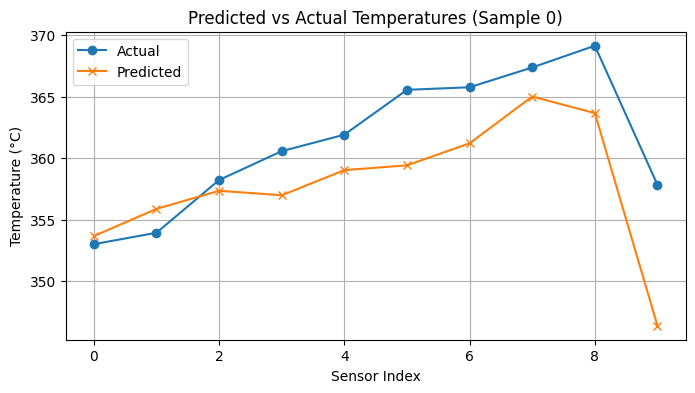

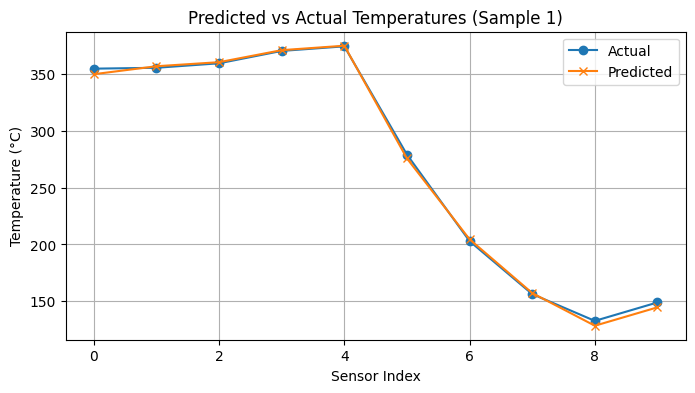

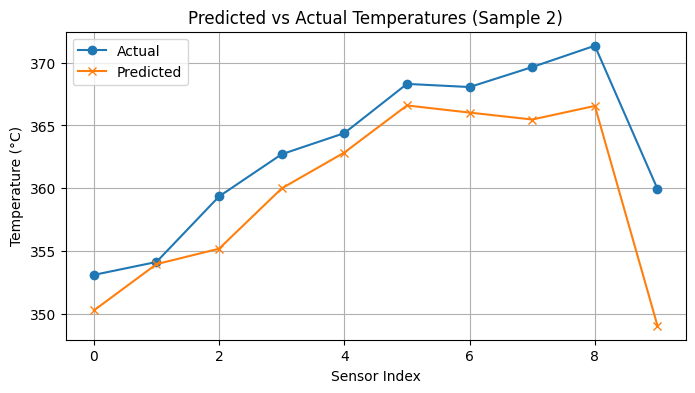

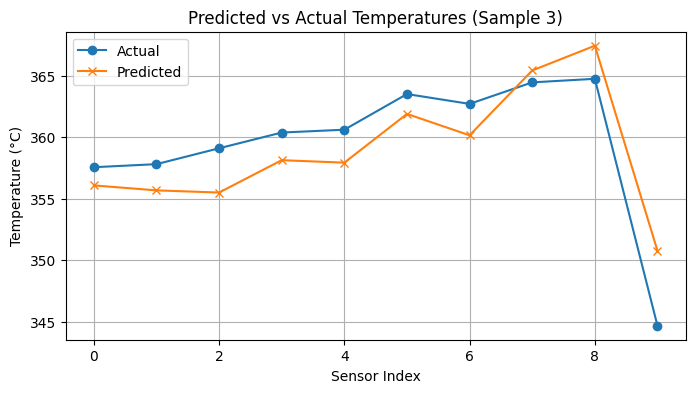

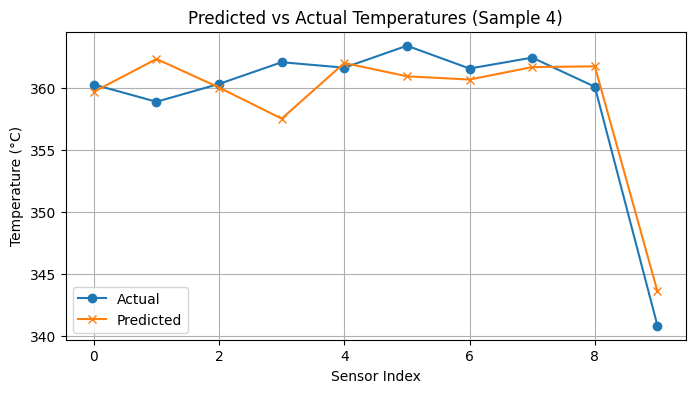

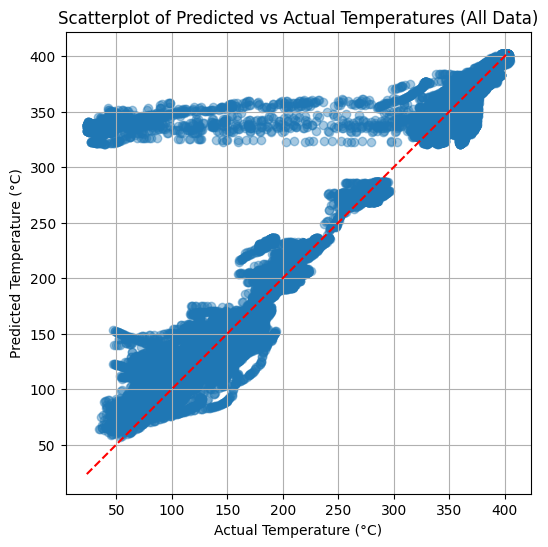

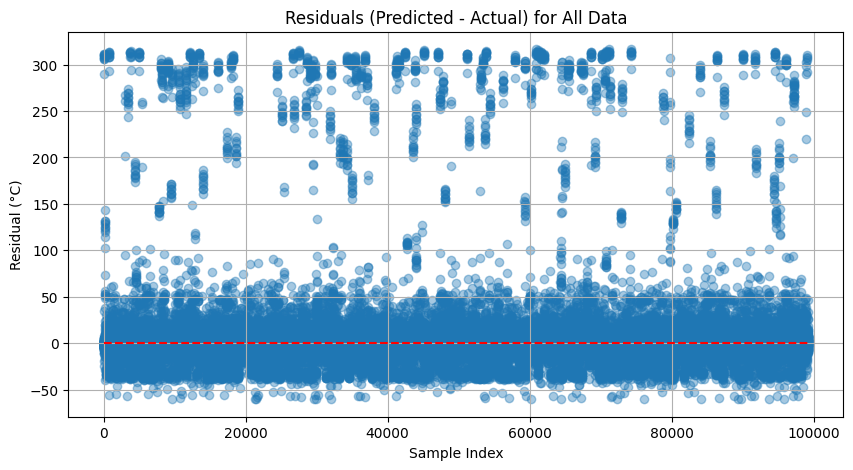

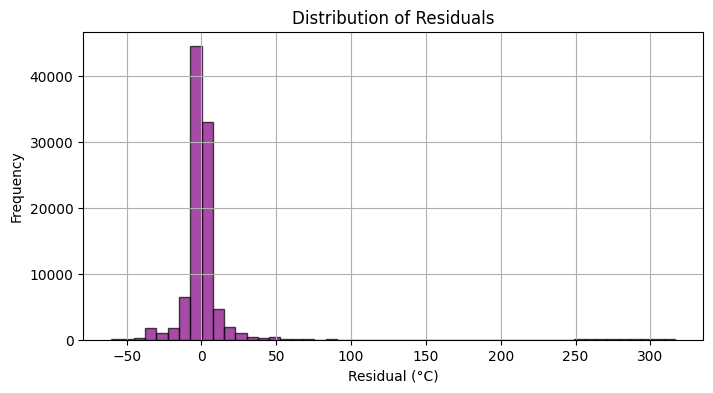

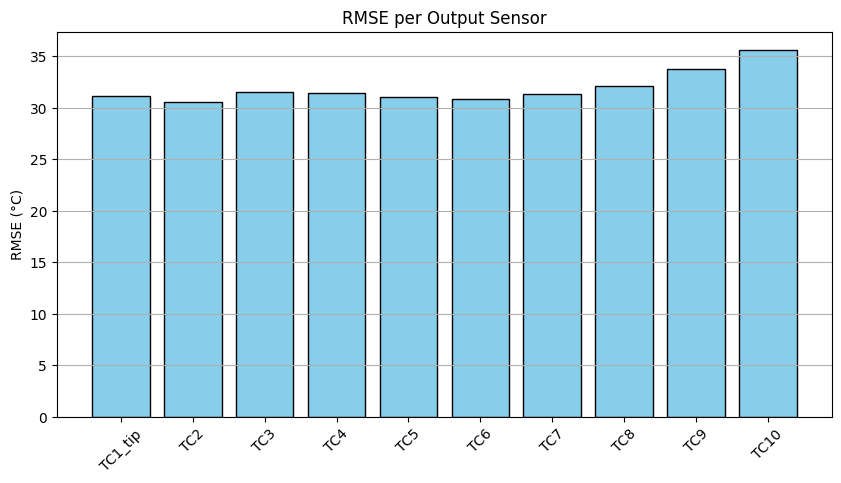

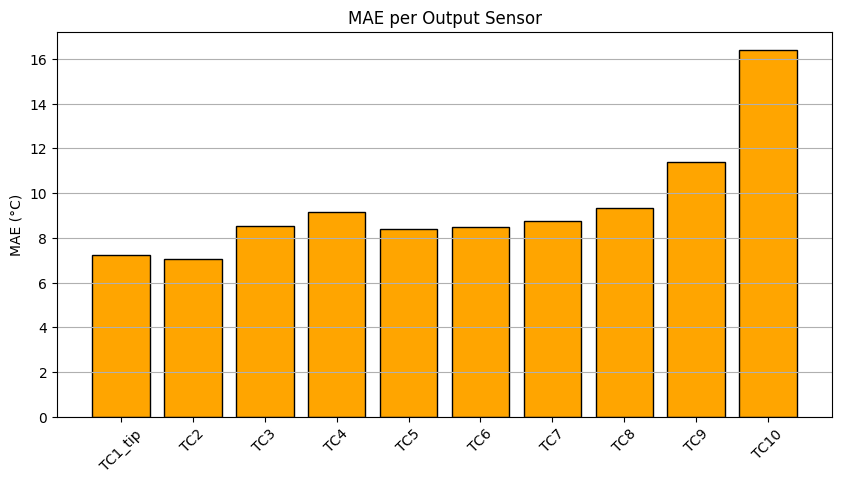

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Predicted vs Actual Temperatures for 5 samples from the test set
num_samples = 5
for idx in range(num_samples):
    plt.figure(figsize=(8, 4))
    plt.plot(y_real[idx], label='Actual', marker='o')
    plt.plot(preds_real[idx], label='Predicted', marker='x')
    plt.title(f'Predicted vs Actual Temperatures (Sample {idx})')
    plt.xlabel('Sensor Index')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Scatterplot

plt.figure(figsize=(6, 6))
plt.scatter(y_real.flatten(), preds_real.flatten(), alpha=0.4)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], color='red', linestyle='--')
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Scatterplot of Predicted vs Actual Temperatures (All Data)")
plt.grid(True)
plt.axis("equal")
plt.show()

#Residuals (Error) Plot
residuals = preds_real - y_real
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals.flatten())), residuals.flatten(), alpha=0.4)
plt.hlines(0, 0, len(residuals.flatten()), colors='red', linestyles='--')
plt.title("Residuals (Predicted - Actual) for All Data")
plt.xlabel("Sample Index")
plt.ylabel("Residual (°C)")
plt.grid(True)
plt.show()

#Residual Distribution Histogram
plt.figure(figsize=(8, 4))
plt.hist(residuals.flatten(), bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#Bar Chart: RMSE per Sensor
plt.figure(figsize=(10, 5))
plt.bar(y.columns, rmse, color='skyblue', edgecolor='black')
plt.title("RMSE per Output Sensor")
plt.ylabel("RMSE (°C)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#Bar Chart: MAE per Sensor
plt.figure(figsize=(10, 5))
plt.bar(y.columns, mae, color='orange', edgecolor='black')
plt.title("MAE per Output Sensor")
plt.ylabel("MAE (°C)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



In [11]:
def check_and_clip_input(input_df, scaler):
    min_vals = scaler.data_min_
    max_vals = scaler.data_max_
    columns = scaler.feature_names_in_
    clipped = False
    for i, col in enumerate(columns):
        val = input_df.iloc[0, i]
        if val < min_vals[i] or val > max_vals[i]:
            print(f"Warning: '{col}' value {val} is out of range [{min_vals[i]}, {max_vals[i]}]. Clipping.")
            input_df.iloc[0, i] = min(max(val, min_vals[i]), max_vals[i])
            clipped = True
    if not clipped:
        print("All input values are within the training range.")
    return input_df

In [12]:
new_input = [
    [  # Full input vector for inference
        571,     # Time (seconds)
        0.0375,     # Depth (h)
        25900,      # Heat flux (q0)
        3,          # Absorption coefficient (abs)
        0.98        # Surface emissivity (surf)
    ] + [362.19,358.26,333.06,183.66,124.89,82.55,64.62,52.62,42.62,40.52]  # Theoretical temperature values at 10 vertical points
]

X_scaler = joblib.load("X_scaler.pkl")
y_scaler = joblib.load("y_scaler.pkl")

# Create DataFrame with correct columns
theory_cols = [f"Theoretical_Temps_{i+1}" for i in range(10)]
input_columns = ["Time", "h", "flux", "abs", "surf"] + theory_cols
new_input_df = pd.DataFrame(new_input, columns=input_columns)

# Clip out-of-range values before scaling
new_input_df = check_and_clip_input(new_input_df, X_scaler)

new_input_scaled = X_scaler.transform(new_input_df)
new_tensor = torch.tensor(new_input_scaled, dtype=torch.float32)

input_size = len(new_input[0])               # Should be 15
output_size = len(y_scaler.scale_)           # Should be 10 if you're predicting TC1–TC10
model = NeuralNet(input_size, output_size)
model.load_state_dict(torch.load("thermal_model_weights.pth"))
print("Model loaded. First layer weights (sample):", model.net[0].weight[0][:5])
model.eval()

with torch.no_grad():
    pred = model(new_tensor).numpy()
    
real_pred = y_scaler.inverse_transform(pred)
print("\nPredicted Temperatures:", real_pred)

Model loaded. First layer weights (sample): tensor([ 0.1330, -0.1140, -0.0501,  0.1212, -0.2431], grad_fn=<SliceBackward0>)

Predicted Temperatures: [[367.93576  368.75208  383.8451   331.24036  333.5436   231.93723
  186.59888  118.00723   99.650246  70.7392  ]]
